## **VGG-19 CNN Model**

### **1. Import the necessary libraries**


In [60]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [61]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Load and Preprocess Data**


In [62]:
# Set paths to your dataset
train_dir = "./DATASETS/resized_dataset_256/train"
val_dir = "./DATASETS/resized_dataset_256/val"
test_dir = "./DATASETS/resized_dataset_256/test"

# Define image size and batch size
img_size = (256, 256)
batch_size = 12

# Use ImageDataGenerator for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Evaluate on test set
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=12,
    class_mode="categorical",
    shuffle=False,
)

Found 48 images belonging to 4 classes.


### **4. Building VGG-19 Model**


In [63]:
def create_vgg19_model(learning_rate=0.001, dropout_rate=0.0):
    # Load pre-trained VGG19 model without top layers
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

    # Freeze initial layers to keep pre-trained weights unchanged
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for MRI classification task
    x = Flatten()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **5. Train the Model**


In [64]:
# # Define parameter grid
# param_grid = {
#     "learning_rate": [0.01, 0.001, 0.0001],
#     "batch_size": [12, 24],
#     "dropout_rate": [0.0, 0.5],
# }

# Define parameter grid
param_grid = {
    "learning_rate": [0.001],
    "batch_size": [12],
    "dropout_rate": [0.5],
}


# Create combinations of parameters
grid = list(ParameterGrid(param_grid))

# List to store results
results = []

# Initialize variables to keep track of the best model
best_val_accuracy = 0.0
best_params = None
best_model = None
best_history = None

# Iterate over parameter combinations
for params in grid:
    # Create model with current parameters
    model = create_vgg19_model(
        learning_rate=params["learning_rate"], dropout_rate=params["dropout_rate"]
    )

    # Set up data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=params["batch_size"],
        class_mode="categorical",
    )

    valid_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=params["batch_size"],
        class_mode="categorical",
        shuffle=False,
    )

    # Define callbacks
    early_stop = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // params["batch_size"],
        epochs=20,
        validation_data=valid_generator,
        validation_steps=valid_generator.n // params["batch_size"],
        callbacks=[early_stop],
        verbose=1,
    )

    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    # Save results
    results.append(
        {
            "params": params,
            "history": history.history,
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
        }
    )

    # Check if current model is the best one based on validation accuracy
    if history.history["val_accuracy"][-1] > best_val_accuracy:
        best_val_accuracy = history.history["val_accuracy"][-1]
        best_params = params
        best_model = model
        best_history = history.history

# Save the best model
best_model.save("vgg19_model.h5")

# Print and save best results
print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Test Accuracy: {results[-1]['test_accuracy']}")
print(f"Test Loss: {results[-1]['test_loss']}")

Found 336 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
28/28 [==============================] - 5s 147ms/step - loss: 45.2600 - accuracy: 0.4167 - val_loss: 12.7179 - val_accuracy: 0.7292
Epoch 2/20
28/28 [==============================] - 4s 141ms/step - loss: 13.8862 - accuracy: 0.6369 - val_loss: 3.8115 - val_accuracy: 0.8021
Epoch 3/20
28/28 [==============================] - 4s 136ms/step - loss: 9.4135 - accuracy: 0.6935 - val_loss: 4.9892 - val_accuracy: 0.6979
Epoch 4/20
28/28 [==============================] - 4s 135ms/step - loss: 4.2946 - accuracy: 0.7173 - val_loss: 2.7096 - val_accuracy: 0.7396
Epoch 5/20
28/28 [==============================] - 4s 134ms/step - loss: 3.2201 - accuracy: 0.7024 - val_loss: 0.8295 - val_accuracy: 0.8646
Epoch 6/20
28/28 [==============================] - 4s 135ms/step - loss: 2.0492 - accuracy: 0.7232 - val_loss: 1.7760 - val_accuracy: 0.7188
Epoch 7/20
28/28 [==============================] - 4s 132ms/ste

### **6. Evaluate and Visualize Results**


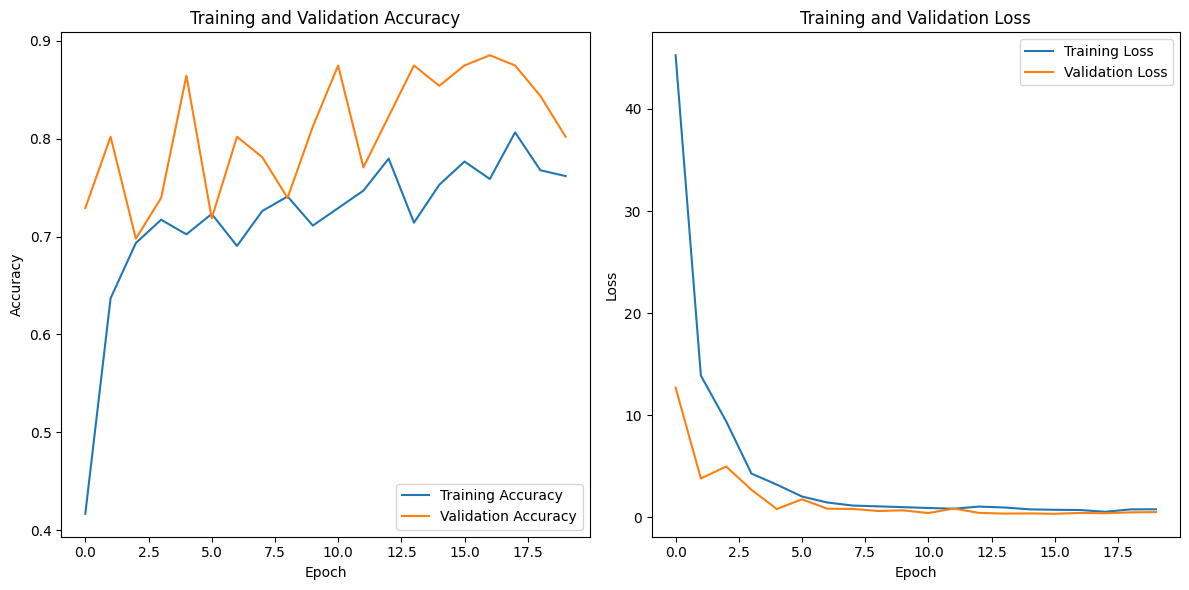

4/4 [==============================] - 1s 54ms/step - loss: 0.4623 - accuracy: 0.7917
Test Accuracy: 0.7917
Test Loss: 0.4623


In [68]:
# Plot best model training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(best_history["accuracy"], label="Training Accuracy")
plt.plot(best_history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history["loss"], label="Training Loss")
plt.plot(best_history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

### **6. Evaluation on test set**


4/4 [==============================] - 1s 131ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.83      0.91        12
  meningioma       0.83      0.83      0.83        12
   pituitary       0.80      1.00      0.89        12
     notumor       1.00      0.92      0.96        12

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.91      0.90      0.90        48



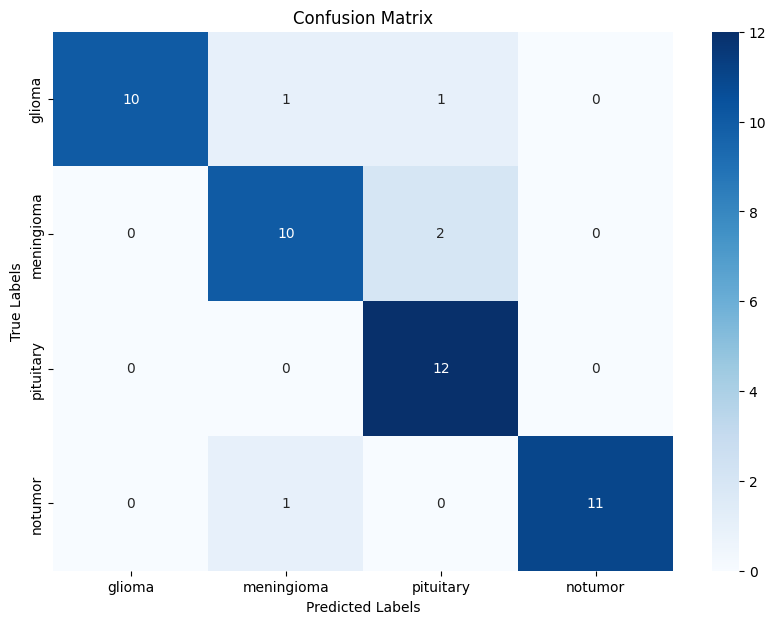

In [69]:
# Load the best saved model
mode_name = "vgg19_model.h5"
model = load_model(mode_name)

# Recompile the model with the correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # or any other optimizer you want to use
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Predict the labels for the test set
categories = ["glioma", "meningioma", "pituitary", "notumor"]
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:\n")
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()